In [1]:
#This data has been gathered at two solar power plants in India over a 34 day period. 

#It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. 

#The power generation datasets are gathered at the inverter level - each inverter has multiple lines of 
#solar panels attached to it. 

#The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.



In [2]:
#There are a few areas of concern at the solar power plant -

# 1) Can we predict the power generation for next couple of days? - this allows for better grid management
# 2) Can we identify the need for panel cleaning/maintenance?
# 3) Can we identify faulty or suboptimally performing equipment?

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [18]:
df_yield = pd.read_csv("Plant_1_Generation_Data.csv")


In [19]:
print(np.sum(df_yield.isna(),axis=0))

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [20]:
df_weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")


In [21]:
print(np.sum(df_weather.isna(),axis=0))

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [22]:
source_keys = np.unique(df_yield['SOURCE_KEY'])

In [23]:
# Fem un drop de la columna PLANT_ID als dos datasets

In [24]:
df_yield = df_yield.drop(["PLANT_ID"], axis=1)
df_weather = df_weather.drop(["PLANT_ID","SOURCE_KEY"], axis=1)


In [25]:
inverters_list = [ (df_yield.loc[df_yield['SOURCE_KEY']== inverter]).reset_index() for inverter in source_keys]
inverters_list = [inverter.drop(['index'],axis=1) for inverter in inverters_list]

for i in range(len(inverters_list)):
    inverters_list[i]['DATE_TIME'] = pd.to_datetime(inverters_list[i]['DATE_TIME'])
df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'])

inverters_list = [pd.merge(inverter, df_weather, on='DATE_TIME', how='inner') for inverter in inverters_list]



In [26]:
#Fem un split del date time en noves columnes pels dies, hores, minuts, etc


for i in range(len(inverters_list)):
    inverters_list[i]['DAY'] = inverters_list[i]['DATE_TIME'].dt.day
    inverters_list[i]['MONTH'] = inverters_list[i]['DATE_TIME'].dt.month
    inverters_list[i]['YEAR'] = inverters_list[i]['DATE_TIME'].dt.year
    inverters_list[i]['HOUR'] = inverters_list[i]['DATE_TIME'].dt.hour
    inverters_list[i]['MINUTE'] = inverters_list[i]['DATE_TIME'].dt.minute
    inverters_list[i]['SECOND'] = inverters_list[i]['DATE_TIME'].dt.second
    inverters_list[i] = inverters_list[i].drop(['DATE_TIME','SECOND','YEAR'], axis=1)
    inverters_list[i]['AC_POWER_mean'] = inverters_list[i]['AC_POWER'].rolling(10).mean()

In [27]:

#Farem predicció sobre el primer inverter
first_inverter_df = inverters_list[0]
first_inverter_df = first_inverter_df.drop(['SOURCE_KEY','DC_POWER'],axis=1)
first_inverter_df.head(20)


,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,HOUR,MINUTE,AC_POWER_mean
0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,15,5,0,0,NaN
1,0.0,0.0,6259559.0,25.084589,22.761668,0.0,15,5,0,15,NaN
2,0.0,0.0,6259559.0,24.935753,22.592306,0.0,15,5,0,30,NaN
3,0.0,0.0,6259559.0,24.846130,22.360852,0.0,15,5,0,45,NaN
4,0.0,0.0,6259559.0,24.621525,22.165423,0.0,15,5,1,0,NaN
5,0.0,0.0,6259559.0,24.536092,21.968571,0.0,15,5,1,15,NaN
6,0.0,0.0,6259559.0,24.638674,22.352926,0.0,15,5,1,30,NaN
7,0.0,0.0,6259559.0,24.873022,23.160919,0.0,15,5,1,45,NaN
8,0.0,0.0,6259559.0,24.936930,23.026113,0.0,15,5,2,0,NaN
9,0.0,0.0,6259559.0,25.012248,23.343229,0.0,15,5,2,15,0.0


In [28]:
first_inverter_df = first_inverter_df.dropna()
first_inverter_df

,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,HOUR,MINUTE,AC_POWER_mean
9,0.0,0.0,6259559.0,25.012248,23.343229,0.0,15,5,2,15,0.0
10,0.0,0.0,6259559.0,25.005149,23.639459,0.0,15,5,2,30,0.0
11,0.0,0.0,6259559.0,24.993020,24.039486,0.0,15,5,2,45,0.0
12,0.0,0.0,6259559.0,25.016309,24.384136,0.0,15,5,3,0,0.0
13,0.0,0.0,6259559.0,24.985215,24.351508,0.0,15,5,3,15,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2094,0.0,5521.0,6485319.0,22.150570,21.480377,0.0,17,6,22,45,0.0
2095,0.0,5521.0,6485319.0,22.129816,21.389024,0.0,17,6,23,0,0.0
2096,0.0,5521.0,6485319.0,22.008275,20.709211,0.0,17,6,23,15,0.0
2097,0.0,5521.0,6485319.0,21.969495,20.734963,0.0,17,6,23,30,0.0


In [29]:
import xgboost as xgb
import math

def r2_eval(Y_pred, train_data):
    labels = train_data.get_label()
    r2 = r2_score(labels, Y_pred)
    return 'r2', r2

def mae_eval(Y_pred, train_data):
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, Y_pred)
    return 'mae', mae

def add_lagged_features(df, num_lags, test_size=0.1):
    #Hem fet el shift correctament de tal manera que el test només té valors lagged del train
    for i in range(1,num_lags):
        df[f'AC_POWER_t{i}'] = df['AC_POWER'].shift(math.floor(test_size*len(df)) + num_lags - i)
        df[f'IRRADIATION_t{i}'] = df['IRRADIATION'].shift(math.floor(test_size*len(df)) + num_lags - i)
        df[f'AMB_TEMP_t{i}'] = df['AMBIENT_TEMPERATURE'].shift(math.floor(test_size*len(df)) + num_lags - i)
        #df[f'MOD_TEMP_t{i}'] = df['MODULE_TEMPERATURE'].shift(math.floor(test_size*len(df)) + num_lags - i)
        df[f'AC_POWER_mean_t{i}'] = df['AC_POWER_mean'].shift(math.floor(test_size*len(df)) + num_lags - i)
        
    return df.dropna()

def make_target(df, attribute_name):
    Y = df[attribute_name]
    return df.drop([attribute_name,'IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','AC_POWER_mean'],axis=1), Y
    

lagged_df = add_lagged_features(first_inverter_df,20,0.1)

X, Y = make_target(lagged_df, 'AC_POWER')



In [30]:
X.head(10)

,DAILY_YIELD,TOTAL_YIELD,DAY,MONTH,HOUR,MINUTE,AC_POWER_t1,IRRADIATION_t1,AMB_TEMP_t1,AC_POWER_mean_t1,...,AMB_TEMP_t17,AC_POWER_mean_t17,AC_POWER_t18,IRRADIATION_t18,AMB_TEMP_t18,AC_POWER_mean_t18,AC_POWER_t19,IRRADIATION_t19,AMB_TEMP_t19,AC_POWER_mean_t19
237,5324.125000,6276929.125,17,5,14,0,0.0,0.0,25.012248,0.0,...,24.011635,3.044821,60.685714,0.049410,23.976731,9.113393,119.275000,0.095394,24.218990,21.040893
238,5459.714286,6277064.714,17,5,14,15,0.0,0.0,25.005149,0.0,...,23.976731,9.113393,119.275000,0.095394,24.218990,21.040893,170.014286,0.141940,24.537398,38.042321
239,5545.857143,6277150.857,17,5,14,30,0.0,0.0,24.993020,0.0,...,24.218990,21.040893,170.014286,0.141940,24.537398,38.042321,181.937500,0.154713,24.815960,56.236071
240,5698.375000,6277303.375,17,5,14,45,0.0,0.0,25.016309,0.0,...,24.537398,38.042321,181.937500,0.154713,24.815960,56.236071,180.585714,0.148799,24.988790,74.294643
241,5937.285714,6277542.286,17,5,15,0,0.0,0.0,24.985215,0.0,...,24.815960,56.236071,180.585714,0.148799,24.988790,74.294643,184.062500,0.144793,25.216180,92.700893
242,6119.125000,6277724.125,17,5,15,15,0.0,0.0,24.937732,0.0,...,24.988790,74.294643,184.062500,0.144793,25.216180,92.700893,318.671429,0.201639,25.419513,124.568036
243,6303.000000,6277908.000,17,5,15,30,0.0,0.0,24.879100,0.0,...,25.216180,92.700893,318.671429,0.201639,25.419513,124.568036,384.837500,0.345708,25.959082,163.051786
244,6429.750000,6278034.750,17,5,15,45,0.0,0.0,24.678902,0.0,...,25.419513,124.568036,384.837500,0.345708,25.959082,163.051786,424.128571,0.405349,26.430782,205.106071
245,6562.428571,6278167.429,17,5,16,0,0.0,0.0,24.351931,0.0,...,25.959082,163.051786,424.128571,0.405349,26.430782,205.106071,417.787500,0.312427,26.831830,244.198571
246,6669.857143,6278274.857,17,5,16,15,0.0,0.0,24.062622,0.0,...,26.430782,205.106071,417.787500,0.312427,26.831830,244.198571,559.228571,0.623153,27.620970,294.052857


Farem una primera prova amb el XGBoostRegressor

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=42)

train_data = xgb.DMatrix(X_train,label = Y_train)
test_data = xgb.DMatrix(X_test, label = Y_test)

params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:squarederror'
}


In [32]:
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

HOUR                0.691708
IRRADIATION_t18     0.048387
AC_POWER_mean_t2    0.021696
AC_POWER_t17        0.016580
AC_POWER_mean_t5    0.015607
                      ...   
IRRADIATION_t2      0.000168
IRRADIATION_t9      0.000140
IRRADIATION_t5      0.000123
AC_POWER_t2         0.000112
MONTH               0.000000
Length: 82, dtype: float32


In [33]:

mae = mean_absolute_error(Y_test, Y_test_pred)
print(f" Test MAE Score: {mae}")

mae = mean_absolute_error(Y_train, Y_train_pred)
print(f"Train MAE Score: {mae}")

 Test MAE Score: 75.98598891547526
Train MAE Score: 3.5334897384055446


In [34]:
r2 = r2_score(Y_test, Y_test_pred)
print(f" Test r2 Score: {r2}")

r2 = r2_score(Y_train, Y_train_pred)
print(f"Train r2 Score: {r2}")

 Test r2 Score: 0.8157609366605673
Train r2 Score: 0.9997860550521673


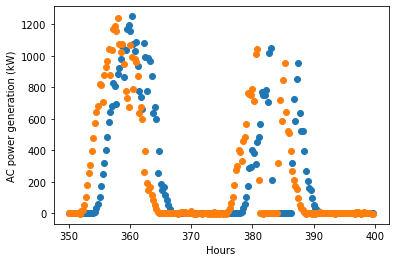

In [35]:
#Valors reals del train vs valors predict del train
x = np.arange(1400,1600)
plt.scatter(x/4, Y_train[x+228])
plt.scatter(x/4, Y_train_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

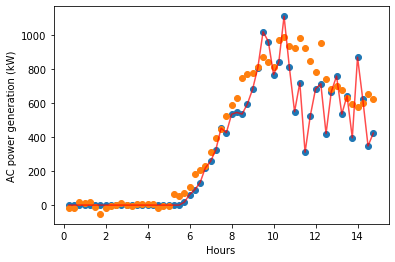

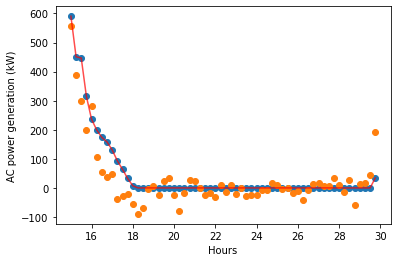

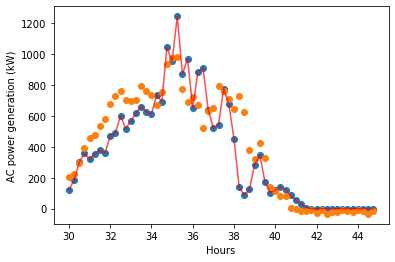

In [36]:
#for i in range(0,180,60):
x = np.arange(1,60)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(60,120)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(120,180)
plt.scatter(x/4, Y_test[x+1911])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.scatter(x/4,Y_test_pred[x])
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

In [37]:
np.set_printoptions(precision=6, suppress=True)

#Aqui calculem el MAPE però només quans els valors reals no son 0 perquè sinó ens donaria infinit, 
#és a dir, només ho calculem quant és de dia, que ve a ser la part que més ens importa

mean_rel_err = 0
cnt = 0
for real, pred in zip(np.array(Y_test),np.array(Y_test_pred)):
    if (real != 0):
        mean_rel_err += abs(real - pred)/ real
        cnt +=1
    
mean_rel_err = mean_rel_err / cnt
print(mean_rel_err)

0.5724709363602821


Amb el millor model amb XGBoost, durant el dia en mitjana ens desviem un 36% del valor real. Encara hi ha molt marge de millora, provem fent un grid_search amb diferents models i paràmetres.

In [38]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit



/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [40]:


dt_regressor = DecisionTreeRegressor(max_depth=15,min_samples_split=5,min_samples_leaf=4)

models = { 'AdaBoostRegressor':
          {'model': AdaBoostRegressor(base_estimator=dt_regressor),'params': 
           {'n_estimators':[150,200,300,400],'learning_rate': [0.01,0.1,1,2],'loss':['linear','square','exponential']}},
          
           'XGBoost':
          {'model':xgb.XGBRegressor(),'params':
           {'n_estimators': [50, 100, 150,400],'learning_rate': [0.01, 0.1, 1],'max_depth': [3,10,15,20]}},
         }

best_models = {}
#ATENCIÓ: això pot trigar varios (molts) minuts en executar-se
for model_name, model_params in models.items():
    time_series_cv = TimeSeriesSplit(n_splits=5)
    reg = GridSearchCV(model_params['model'], model_params['params'], cv=time_series_cv, return_train_score=False,verbose=2)
    reg.fit(X_train, Y_train)
    best_models[model_name] = {'model':reg.best_estimator_ ,'params':reg.best_params_ ,'score':reg.best_score_ }


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=150; total time=   1.3s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=150; total time=   2.1s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=150; total time=   2.9s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=150; total time=   3.7s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   1.7s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   2.8s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   3.9s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   5.0s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=300; total time=   1.2s
[CV] END ..learning_rate=0.01, loss=linear, n_e

[CV] END learning_rate=0.1, loss=exponential, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=150; total time=   1.4s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=150; total time=   2.1s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=150; total time=   3.0s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=150; total time=   3.9s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   1.8s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   5.1s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=300; total time=   1.0s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=300; total time=   2.6s
[CV]

[CV] END .....learning_rate=2, loss=square, n_estimators=150; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=150; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=150; total time=   0.3s
[CV] END .....learning_rate=2, loss=square, n_estimators=150; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=200; total time=   0.1s
[CV] END .....learning_rate=2, loss=square, n_estimators=200; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=200; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=200; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=200; total time=   0.4s
[CV] END .....learning_rate=2, loss=square, n_estimators=300; total time=   0.2s
[CV] END .....learning_rate=2, loss=square, n_estimators=300; total time=   0.3s
[CV] END .....learning_rate=2, loss=square, n_estimators=300; total time=   0.3s
[CV] END .....learning_rate=

[CV] END ..learning_rate=0.01, max_depth=20, n_estimators=50; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=20, n_estimators=50; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.2s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   1.2s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   1.4s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=100; total time=   2.4s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=150; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=150; total time=   1.8s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=150; total time=   2.4s
[CV] END .learning_rate=0.01, max_depth=20, n_estimators=150; total time=   3.2s
[CV] END .learning_rate=0.01

[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=150; total time=   0.4s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=150; total time=   0.4s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=150; total time=   0.3s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=400; total time=   0.4s
[CV] END .....learning_rate=

In [41]:
#Score dels models segons GridSearch
for model_name, model_params in best_models.items():
    print(model_name, " amb paràmetres ", model_params['params'], " té un score de ", model_params['score'])

AdaBoostRegressor  amb paràmetres  {'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 400}  té un score de  0.5764154184182256
XGBoost  amb paràmetres  {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 400}  té un score de  0.5522664771631095


In [42]:
#Score segons la nostra mètrica escollida
for model_name, model_params in best_models.items():
    Y_test_pred = model_params['model'].predict(X_test)
    Y_train_pred = model_params['model'].predict(X_train)
    
    mae = mean_absolute_error(Y_test, Y_test_pred)
    print(f"Test MAE Score for {model_name}: {mae}")

    mae = mean_absolute_error(Y_train, Y_train_pred)
    print(f"Train MAE Score for {model_name}: {mae}")
    

Test MAE Score for AdaBoostRegressor: 67.0374037290879
Train MAE Score for AdaBoostRegressor: 8.42574395411088
Test MAE Score for XGBoost: 64.23462126526925
Train MAE Score for XGBoost: 8.57089743451077


In [43]:
mean_rel_err = 0
cnt = 0
for real, pred in zip(np.array(Y_test),np.array(Y_test_pred)):
    if (real != 0):
        mean_rel_err += abs(real - pred)/ real
        cnt +=1
    
mean_rel_err = mean_rel_err / cnt
print(mean_rel_err)

0.423135348581849


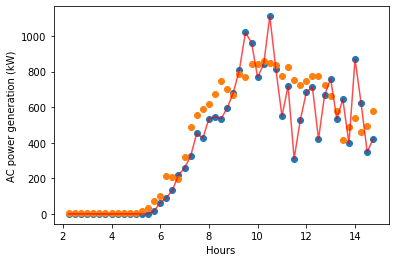

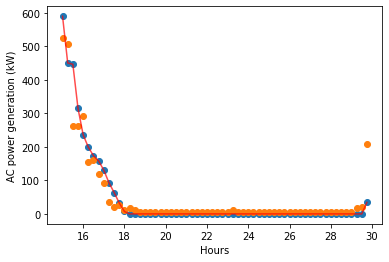

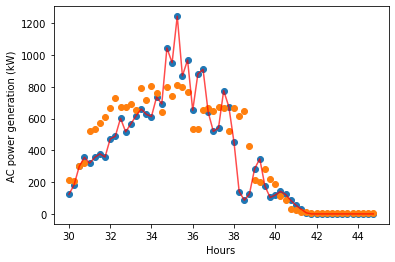

In [44]:
#for i in range(0,180,60):
x = np.arange(9,60)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()


x = np.arange(60,120)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()

x = np.arange(120,180)
plt.scatter(x/4, Y_test[x+1911])
plt.scatter(x/4,Y_test_pred[x])
plt.plot(x/4, Y_test[x+1911], linestyle='-', color='red', alpha=0.7, label='Connected')
plt.xlabel('Hours')
plt.ylabel('AC power generation (kW)')

plt.show()